### Giriş

*   Onur Dilaver Yarar
*   B180102045


**Bilgi:** Bu çalışma Python dilinin 3.9 sürümüyle ve Jupyter Lab üzerinde yazılmıştır.

Üretimlerde makinelerin ne zaman arıza vereceği tam olarak bilinmemektedir. Makinenin bozulması tahmin edilerek ne zaman bakım yapılacağı da bilinir. Böylece üretimde en az durmayla makine arızaları atlatılır. 

Bu çalışmada bir makinenin bozulma verileri üzerinden yola çıkılmıştır. Bu veriler bir karar ağacı olan LightGBM ve Lojistik Regresyon ile modelleri eğitilmiş sonra en baştan arıza verip vermeyeceği sınıflandırma tahmini yapılmıştır. Sonra her modelde hangi özniteliğin daha önemli ona bakılmıştır. Böylece hangi model daha iyi ve makinenin neye göre bozulduğu öğrenilebilir.

Kullanılan veri seti: https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset

### Kütüphane Yükleme

In [80]:
import pandas as pd  # Veri yapıları ile çalışmak için pandas modülü.
import numpy as np # Dizi işlemleri için numpy modülü.
import matplotlib.pyplot as plt # Grafikler için matplotlib modülü.
import lightgbm as lgb # LightGBM modülü lgb olarak yüklenir.
from sklearn import metrics # Performans değerlendirmleri için modül
from sklearn.model_selection import train_test_split # veriyi eğitim ve test diye ayırmak için modül
import seaborn as sns # grafik(pasta) çizdirmek için seaborn modülü sns olarak yüklenir

### Veri İnceleme

In [81]:
df = pd.read_csv('ai4i2020.csv', sep=',', index_col=0) # veri seti .csv dosyasından okunur ve df değişkenine atanır.
df

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
UDI,,,,,,,,,,,,,
1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0


In [82]:
df.info() # veri seti ile ilgili bilgiler

# tool wear failure (TWF)
# heat dissipation failure (HDF)
# power failure (PWF)
# overstrain failure (OSF)
# random failures (RNF)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product ID               10000 non-null  object 
 1   Type                     10000 non-null  object 
 2   Air temperature [K]      10000 non-null  float64
 3   Process temperature [K]  10000 non-null  float64
 4   Rotational speed [rpm]   10000 non-null  int64  
 5   Torque [Nm]              10000 non-null  float64
 6   Tool wear [min]          10000 non-null  int64  
 7   Machine failure          10000 non-null  int64  
 8   TWF                      10000 non-null  int64  
 9   HDF                      10000 non-null  int64  
 10  PWF                      10000 non-null  int64  
 11  OSF                      10000 non-null  int64  
 12  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1.1+ MB


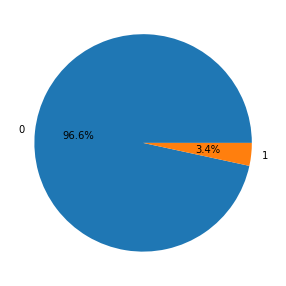

In [83]:
plt.figure(figsize=(5,5)); # grafik çizdirmek için bir alan oluşturulur.
plt.pie(df['Machine failure'].value_counts(), # makine hatası kısmı değerleri
        labels=df['Machine failure'].unique(), # makine hatası değerlerinden 0 ve 1
        autopct='%1.1f%%') # yüzdeli yazdırmak
plt.show() # grafiği göster

In [84]:
print(df['Product ID'].nunique()) # ürün id'sinde tüm değerler birbirinden farklı mı diye bakılır.
print(df['Type'].nunique()) # Type'ında kaç farklı veri var diye bakılır.

10000
3


### Veri Ön İşleme

In [85]:
df.drop(['Product ID','TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True) # verisetindeki ürün id'si ve eğer 1 olursa makine hatasını 1 yapacak öznitelikler çıkartılır. her ürün id'si birbirinden farklı olduğundan olduğu için makine arızasını etkilemez. Ayrıca TWF, HDF gibi hata türleri de çıkartılır. Çünkü onların olması makine arıza özniteliğimizi 1 yapacağı için modeli zorlaştırmak istedim.

df.rename(columns={'Air temperature [K]':'Air temperature', 'Process temperature [K]':'Process temperature', 'Rotational speed [rpm]':'Rotational speed', 'Torque [Nm]':'Torque', 'Tool wear [min]':'Tool wear'}, inplace=True) # lightgbm sınıflandırma yaparken sütunlarda köşeli parantezler varsa hata veriyor. o yüzden sütun isimleri değiştirilir.

In [86]:
df = pd.get_dummies(df, columns=["Type"]) # makine öğrenmesi, kategorik verilerin sayılara dönüştürülmesini gerektiriyor. Bu yüzden 'Type' kategorik öznitelik olduğu için numerik özniteliklere dönüştürülür.

In [87]:
df

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,Type_H,Type_L,Type_M
UDI,,,,,,,,,
1,298.1,308.6,1551,42.8,0,0,0,0,1
2,298.2,308.7,1408,46.3,3,0,0,1,0
3,298.1,308.5,1498,49.4,5,0,0,1,0
4,298.2,308.6,1433,39.5,7,0,0,1,0
5,298.2,308.7,1408,40.0,9,0,0,1,0
...,...,...,...,...,...,...,...,...,...
9996,298.8,308.4,1604,29.5,14,0,0,0,1
9997,298.9,308.4,1632,31.8,17,0,1,0,0
9998,299.0,308.6,1645,33.4,22,0,0,0,1


In [88]:
X = df.drop(['Machine failure'], axis=1) # Girdi verilerimize Makine arıza hariç hepsi seçilir.
y = df['Machine failure'] # Makine arızasını tahmin etmek istediğimiz için çıktı olarak 'Machine failure' seçilir. 

In [89]:
# x'lerden ve y'den oluşan 4 adet yeni df oluşturur. test büyüklüğümüz toplam veri setimizin yüzde 25'i olacaktır. random_state her modülü çalıştırdığımızda aynı veri setlerini üretebilmek için kullanılır.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Verilerimizin dağılışına göre ölçeklendirme yapacağımız için verilerin dağılımına Minitab yardımıyla bakılır. Minitab'den 'Normality Test' yapılarak verilerimizin normal olup olmadığını ise p-value(p değeri) ile anlayabiliriz. Normality test grafikleri aşağıdadır. Eğer p-değeri 0.05'ten küçükse verimiz normal dağılıma uymaz. Bundan dolayı bizim verilerimizin çoğunun normal dağılıma uymadığı görülür. 

![Alt_text](https://i.imgur.com/d1u74dh.png)

Ama ben modellerimde karar ağaçları ve lojistik regresyon kullandığım için ölçeklendirmeye gerek duymadım. Çünkü ölçeklendirmenin ana amacı doğruluktan çok az feragat ederek sonuca daha hızlı ulaşmaktır. Ağaç bazlı modellerde özniteliklerin ölçeği önemli değildir. 

### Modelleme(LightGBM)

**LightGBM:** Denetimli makine öğrenimine girer. Karar ağacı yöntemidir. 
Karar ağaçları, tek başına zayıf öğrenen modellerdir. Güçlendirmek için boosting yöntemleri kullanılır. Boosting, topluluk öğrenme (ensemble learning) yöntemlerinden biridir. Zayıf öğrenicileri güçlü öğrenicilere dönüştürme işlemidir. LightGBM de bunlardan biridir. Microsoft tarafından geliştirilmiş olup yeni sayılan bir algoritmadır. Yeni olduğundan dolayı hakkındaki doküman, diğer boosting çeşitleri kadar fazla değildir. 

In [90]:
lgb_clf = lgb.LGBMClassifier(random_state=68) # model lightgbm için yapılacağı için modül yüklenir. varsayılan parametreleri iledir.

lgb_clf.fit(X_train, y_train)  # eğitim gerçekleştir.

y_pred = lgb_clf.predict(X_test) # X_test'ten y değerleri tahmin edilip y_pred'e atanır.

___

In [91]:
# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.

# Eğitim skoru
y_pred_train = lgb_clf.predict(X_train)
print('LightGBM Model eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, y_pred_train)))

# Test skoru
accuracy_lightgbm = metrics.accuracy_score(y_pred, y_test)
print('LightGBM Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))

LightGBM Model eğitim veri seti doğruluğu: 1.0000
LightGBM Model test veri seti doğruluğu: 0.9876


Değerler yakın olduğu için overfitting ezberleme yoktur diyebiliriz.

### Performans Değerlendirmesi

In [92]:
# Sınıflandırma işlemi sonrası karmaşıklık matrisi ile performans değerlendirmesi yapılır.

print(metrics.confusion_matrix(y_true = y_test, y_pred=y_pred)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

[[2419    9]
 [  22   50]]


Yukarıdaki matris, ikili (binary) sınıflandırma için kurulmuş olan bir modelin çıktısının confusion matrix’idir. 2419 ve 50 doğru tahminlerdir.

Yani bizim gerçek verimizde 2419 kere makinenin arıza yapacağı ve 50 kere arıza yapmayacağı doğru tahmin edilmiştir.

Bir yandan da makine arıza yapmayacakken 9 kere arıza yapacağı ve 22 kere arıza yapacağı zaman da arıza yapmayacak şeklinde tahmin ederek yanlış tahminde bulunmuştur.

![kaynak](https://i.imgur.com/6A8xQ8C.png)

In [93]:
print(metrics.classification_report(y_true = y_test, y_pred=y_pred)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2428
           1       0.85      0.69      0.76        72

    accuracy                           0.99      2500
   macro avg       0.92      0.85      0.88      2500
weighted avg       0.99      0.99      0.99      2500



In [94]:
# doğru yapılan tahmin / toplam yapılan tahmin %99 ile arıza yapıp yapmayacağını
# Modelimizin öngörülen çıktı değerleri ağırlıklı ortalama %99 doğrudur.
# Modelimizle birlikte kaç tane olumlu vakanın doğru tahmin edildiği yüzdesini verir. O da ağırlıklı %99
mcc_lightgbm = round(metrics.matthews_corrcoef(y_test, y_pred),2) # Matthews Correlation Coefficient (MCC) hesaplama
mcc_lightgbm

0.76

*Gerçek veriler ile tahmin edilen veriler arasındaki korelasyon (phi-coefficient) ilişkisine bakarak değerlendirme yapar. MCC, -1 ile 1 arasında değer alır. Çıkan tüm sonuçlara bakarak modelimiz fena olmayan bir sınıflandırma tahmini yapmıştır.*
___

ROC ve AUC sınıflandırmada kullanılan bir başka performans ölçümleridir.

*ROC eğrisi, sınıflandırmada modele ne kadar güvenebileceğimizi gösteren bir grafik türüdür. Eğri, grafiğin sol üst köşesine ne kadar yakın olursa modelin verileri  sınıflandırmada daha iyi olduğu görülür.*

*Eğriyi altında kalan alanı ölçmek için AUC(area under the curve) hesaplanabilir. Sonuç 1'e ne kadar yakınsa model iyidir, 0.5'e eşit olan bir modelse, kötü bir sınıflandırma yapmıştır, denir.*

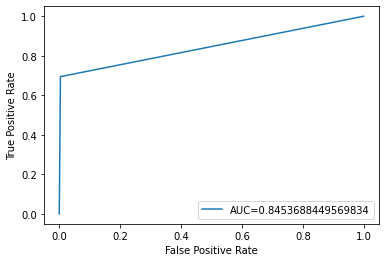

In [95]:
# metrikler tanımlanır
lightfpr, lighttpr, _ = metrics.roc_curve(y_test,  y_pred)
light_auc = metrics.roc_auc_score(y_test, y_pred)

# ROC eğrisi ve AUC hesaplanır.
plt.plot(lightfpr,lighttpr,label="AUC="+str(light_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Feature: 0, Score: 555.00000
Feature: 1, Score: 514.00000
Feature: 2, Score: 582.00000
Feature: 3, Score: 697.00000
Feature: 4, Score: 512.00000
Feature: 5, Score: 40.00000
Feature: 6, Score: 64.00000
Feature: 7, Score: 36.00000


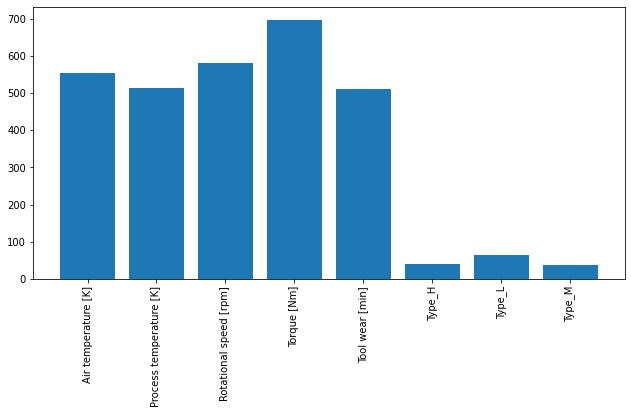

In [96]:
# Özniteliklerin modelimizde ne kadar önemli olduklarını belirtme
importance = lgb_clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# grafiği çizdirilir.
plt.figure(figsize=(10.6,5))
plt.bar([x for x in range(len(importance))], importance)
plt.xticks(range(len(importance)),['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]','Type_H','Type_L','Type_M'], rotation = 90 )
plt.show()

LightGBM modelimizde makine hatasını en çok Tork etkilemiştir.

____
**Lojistik Regresyon ile Sınıflandırma Yapılsaydı**

### Modelleme(Lojistik Regresyon)

**Lojistik Regresyon:** Denetimli makine öğrenimine girer. Girdi ve çıktı verilerini alarak sınıflandırma yaparak çıktı verilerini tahmin eder. Bu çalışmada ikili(binary) lojistik regresyon kullanılmıştır.

In [97]:
from sklearn.linear_model import LogisticRegression # Lojistik regresyon için modüldür.

model = LogisticRegression(random_state=68) # model lojistik regresyon için yapılacağı için modül yüklenir.
model.fit(X_train, y_train)  # eğitim gerçekleştir.

LogisticRegression(random_state=68)

In [98]:
y_tahmin = model.predict(X_test)  # Modeldeki x_testleri tahmin edilir ve y_tahmin değşikenine atanır.

### Performans Değerlendirmesi

In [99]:
print(metrics.confusion_matrix(y_true = y_test, y_pred=y_tahmin)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

[[2417   11]
 [  53   19]]


Lojistik regresyonda hata sayımız 33 artmıştır.
Yukarıdaki matris, ikili (binary) sınıflandırma için kurulmuş olan bir modelin çıktısının confusion matrix’idir. 2417 ve 19 doğru tahminlerdir.

Yani bizim gerçek verimizde 2417 kere makinenin arıza yapacağı ve 19 kere arıza yapmayacağı doğru tahmin edilmiştir.

Bir yandan da makine arıza yapmayacakken 11 kere arıza yapacağı ve 53 kere arıza yapacağı zaman da arıza yapmayacak şeklinde tahmin ederek yanlış tahminde bulunmuştur.

In [100]:
print(metrics.classification_report(y_true = y_test, y_pred=y_tahmin)) # y_true: doğru hedef değişkenleridir. y_pred: sınıflandırma modelinden çıkan tahmin sonuçlarıdır.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2428
           1       0.63      0.26      0.37        72

    accuracy                           0.97      2500
   macro avg       0.81      0.63      0.68      2500
weighted avg       0.97      0.97      0.97      2500



In [101]:
# doğru yapılan tahmin / toplam yapılan tahmin %98 ile kredi verilip verilmeyeceği 
# Modelimizin öngörülen çıktı değerleri ağırlıklı ortalama %97 doğrudur.
# Modelimizle birlikte kaç tane olumlu vakanın doğru tahmin edildiği yüzdesini verir. O da ağırlıklı %98
mcc_logistic = round(metrics.matthews_corrcoef(y_test, y_tahmin),2) # Matthews Correlation Coefficient (MCC) hesaplama
mcc_logistic

0.4

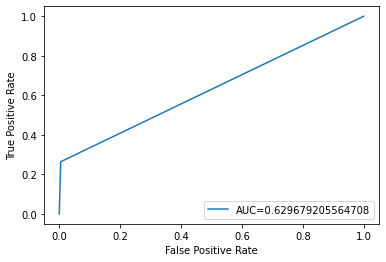

In [102]:
# metrikler tanımlanır
linfpr, lintpr, _ = metrics.roc_curve(y_test,  y_tahmin)
lin_auc = metrics.roc_auc_score(y_test, y_tahmin)

# ROC eğrisi ve AUC hesaplanır.
plt.plot(linfpr,lintpr,label="AUC="+str(lin_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

LightGBM modelimize göre Lojistik regresyon kötü bir sonuç vermiştir.

In [103]:
# Modelimizde overfitting olmuş mu diye bakmak için eğitim skoru ve test skoru karşılaştırılır. eğer değerler yakınsa overfitting yoktur denir.

# Eğitim skoru
y_pred_train = model.predict(X_train)
print('LightGBM Model eğitim veri seti doğruluğu: {0:0.4f}'. format(metrics.accuracy_score(y_train, y_pred_train)))

# Test skoru
accuracy_linear = metrics.accuracy_score(y_tahmin, y_test)
print('LightGBM Model test veri seti doğruluğu: {0:0.4f}'.format(metrics.accuracy_score(y_test, y_tahmin)))

LightGBM Model eğitim veri seti doğruluğu: 0.9687
LightGBM Model test veri seti doğruluğu: 0.9744


### Sonuç

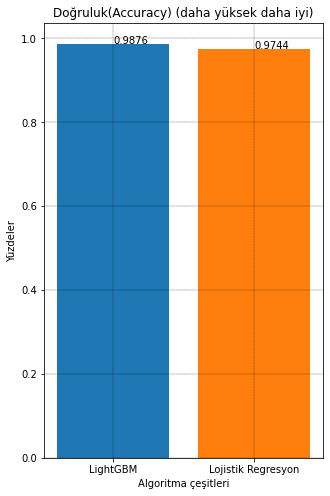

In [104]:
# Doğruluk çubuk grafik(bar) 
acc = ['LightGBM', 'Lojistik Regresyon']
acc_values = [accuracy_lightgbm, accuracy_linear]

col_map = plt.get_cmap('tab10') # her bir çubuğu renklendirmek için matplot'tan get_cmap fonksiyonu ile tab10 renkleri seçilir.
plt.figure(figsize=(5,8)) # 5x8 inçlik bir grafik oluşturmak için grafiğin boyutları belirlenir.
plt.bar(acc, acc_values, color =col_map.colors) # grafik çizdirilir.

# her çubuğun hangi değerde olduğu yazdırılır.
for j, k in zip(acc, acc_values):
    plt.annotate(str(k), xy=(j,k))
    
plt.xlabel("Algoritma çeşitleri") # x ekseni ismi
plt.ylabel("Yüzdeler") # y ekseni ismi
plt.title("Doğruluk(Accuracy) (daha yüksek daha iyi)") # grafik ismi
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3) # kılavuz çizgileri

plt.show() # grafiğı göster

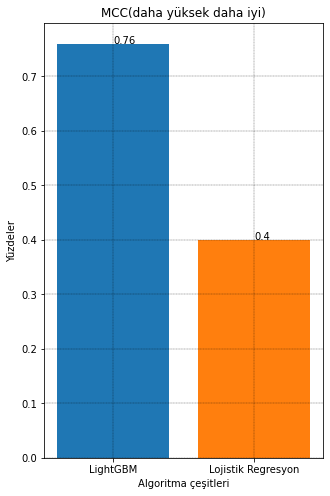

In [105]:
# Doğruluk çubuk grafik(bar) 
mcc = ['LightGBM', 'Lojistik Regresyon']
mcc_values = [mcc_lightgbm, mcc_logistic]

col_map = plt.get_cmap('tab10') # her bir çubuğu renklendirmek için matplot'tan get_cmap fonksiyonu ile tab10 renkleri seçilir.
plt.figure(figsize=(5,8)) # 5x8 inçlik bir grafik oluşturmak için grafiğin boyutları belirlenir.
plt.bar(mcc, mcc_values, color =col_map.colors) # grafik çizdirilir.

# her çubuğun hangi değerde olduğu yazdırılır.
for j, k in zip(mcc, mcc_values):
    plt.annotate(str(k), xy=(j,k))
    
plt.xlabel("Algoritma çeşitleri") # x ekseni ismi
plt.ylabel("Yüzdeler") # y ekseni ismi
plt.title("MCC(daha yüksek daha iyi)") # grafik ismi
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3) # kılavuz çizgileri

plt.show() # grafiğı göster

Sonuç olarak sadece bu performans değerlendirmelerine bakarsak bu veri setinde bu problem için en iyi performansı LightGBM ile elde edilmiştir. 